In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
# data parell

In [ ]:
import pandas as pd

df = pd.read_excel('/home/hyungyu/survival_analysis/paper_ex/new_data_0818.xlsx')
df = df.drop(columns ='event', axis = 1)
df

In [ ]:
import numpy as np

df['label'] = np.where(df['duration']<30, 1, 0)
df

In [4]:
print( 'label 개수 :\n', df["label"].value_counts())


label 개수 :
 label
0    799
1    159
Name: count, dtype: int64


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

In [6]:
class ImageTransform():
    def __init__(self, size, mean, std):
        self.data_transform = {
            'train' : transforms.Compose([
                transforms.RandomResizedCrop(size, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness= 0.3, contrast = 0.4, saturation = 0.3, hue = 0.2),
                # transforms.ColorJitter(brightness= 0.2, contrast = 0.2),
                transforms.RandomAffine(degrees = 15, translate = (0.1, 0.1), shear = (-10, 10)),
                # transforms.RandomAffine(degrees = 15, translate = (0.1, 0.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test' : transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                # fivecrop
                transforms.Normalize(mean, std)
            ])
        }
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [7]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 64

img_trsf = ImageTransform(
    size=size, 
    mean=mean, 
    std=std
)

In [8]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

def denormalize(img, mean=mean, std=std):
    return img * torch.Tensor(std).view(-1,1,1) + torch.Tensor(mean).view(-1,1,1)

class BedsoreDataset(Dataset):
    def __init__(self,df,transform = img_trsf, phase = 'train'):
        self.df = df
        self.transform = transform 
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        file_path = self.df["file_path"].iloc[index]
        img = Image.open(file_path).convert('RGB')
        if self.transform:
            img = self.transform(img, self.phase)
        
        label = self.df["label"].iloc[index]

        return img, label


In [10]:
from sklearn.model_selection import StratifiedGroupKFold

groups = df['num']
labels = df['label']

sss = StratifiedGroupKFold(n_splits = 5, shuffle = False)

In [ ]:
from collections import Counter , defaultdict

In [11]:
result = []   
for train_idx, val_idx in sss.split(df, labels, groups = groups):
    train_df = df.iloc[train_idx]
    test_df = df.iloc[val_idx]
    result.append((train_df, test_df))

In [12]:
print('df ( label = 0 ) count = ', df[df['label'] == 0].shape)
print('-'*20)
print('df ( label = 1 ) count = ', df[df['label'] == 1].shape)
print('-'*20)
print('train_df ( label = 0 ) count = ', train_df[train_df['label'] == 0].shape)
print('-'*20)
print('train_df ( label = 1 ) count = ', train_df[train_df['label'] == 1].shape)
print('-'*20)
print('test_df ( label = 0 ) count = ', test_df[test_df['label'] == 0].shape)
print('-'*20)
print('test_df ( label = 1 ) count = ', test_df[test_df['label'] == 1].shape)
print('-'*20)

df ( label = 0 ) count =  (799, 7)
--------------------
df ( label = 1 ) count =  (159, 7)
--------------------
train_df ( label = 0 ) count =  (640, 7)
--------------------
train_df ( label = 1 ) count =  (127, 7)
--------------------
test_df ( label = 0 ) count =  (159, 7)
--------------------
test_df ( label = 1 ) count =  (32, 7)
--------------------


In [13]:
train_dataset = BedsoreDataset(train_df, phase="train")
test_dataset = BedsoreDataset(test_df, phase="test")

In [ ]:
import matplotlib.pyplot as plt

def show_img(img, label=None, figsize=(10,10)):
    img_denrom = denormalize(img)
    plt.figure(figsize=figsize)
    plt.imshow(img_denrom.permute(1,2,0).numpy())
    if label is not None:
        plt.title(f"Label = {label}")
    plt.axis('off')
    pass

img, label = train_dataset[0]
show_img(img, label=label, figsize=(5,5))

In [15]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)
dataloader_dict = {'train' : train_loader, 'test' : test_loader}
                                   
print(f"[Train]: {len(train_loader)}")
print(f"[Test]: {len(test_loader)}")

[Train]: 6
[Test]: 2


In [16]:
train_batch = next(iter(train_loader))

In [17]:
imgs, labels = train_batch
imgs.shape, labels.shape # input  -> imgs , label -> label

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [ ]:
from torchvision.utils import make_grid

grid_img = make_grid(imgs)
show_img(grid_img,)
# plt.savefig('./sajin.png')

In [19]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")

In [20]:
from torchvision.models import resnet18

net = resnet18(pretrained=True).to(device)
net.fc = nn.Sequential(nn.Linear(net.fc.in_features, 1), nn.Sigmoid())
net

/home/hyungyu/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/hyungyu/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy(inputs.squeeze(),  targets.float())
        loss = self.alpha * (1 - torch.exp(-bce_loss)) ** self.gamma * bce_loss
        return loss

In [22]:
criterion = FocalLoss()
criterion.to(device)
   
net.to(device) 

outputs = net(imgs.to(device))
criterion(outputs.view(-1), labels.to(device).float())

optimizer = optim.Adam(net.parameters(), lr = 1e-4)

In [23]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
import time
from tqdm import tqdm

In [25]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch, patience):
    since = time.time()
    best_acc = 0.0
    best_model_wts = net.state_dict()
    early_stop_count = 0
    
    for epoch in range(num_epoch):
        y_pred = []
        y_true = []
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        for phase in ['train', 'test']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0

            for imgs, labels in tqdm(dataloader_dict[phase]):
                imgs = imgs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imgs)
                    
                    preds = torch.ge(outputs, 0.5).float()
                    outputs = torch.squeeze(outputs, 1)
                    loss = criterion(outputs, labels.float())
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * imgs.size(0)
                    epoch_corrects += torch.sum(torch.squeeze(preds, 1) == labels)
            
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            if phase == 'test':
                if best_acc < epoch_acc:
                    # checkpoint_dir = './checkpoints'
                    
                    savePath = f'/home/hyungyu/survival_analysis/paper_ex/classification/checkpoints/{net.__class__.__name__}.pt'
                    best_model_wts = torch.save(net.state_dict(), savePath)
                    
                    best_acc = epoch_acc
                    early_stop_count = 0
                else:
                    early_stop_count += 1
                    if early_stop_count >= patience:
                        # net.load_state_dict(best_model_wts)
                        print("Early stopping")
                        break
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        if early_stop_count >= patience:
            break
        
        time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return net

In [26]:
num_epoch = 10
model = train_model(net, dataloader_dict, criterion, optimizer, num_epoch, 7)

Epoch 1/10
--------------------


100%|██████████| 6/6 [01:02<00:00, 10.49s/it]


train Loss: 0.2110 Acc: 0.4576


100%|██████████| 2/2 [01:01<00:00, 30.97s/it]


test Loss: 0.1363 Acc: 0.6649
Epoch 2/10
--------------------


100%|██████████| 6/6 [01:00<00:00, 10.03s/it]


train Loss: 0.1356 Acc: 0.6636


100%|██████████| 2/2 [00:57<00:00, 28.55s/it]


test Loss: 0.1522 Acc: 0.6440
Epoch 3/10
--------------------


100%|██████████| 6/6 [01:00<00:00, 10.11s/it]


train Loss: 0.0864 Acc: 0.7875


100%|██████████| 2/2 [00:57<00:00, 28.86s/it]


test Loss: 0.1152 Acc: 0.6911
Epoch 4/10
--------------------


100%|██████████| 6/6 [01:03<00:00, 10.61s/it]


train Loss: 0.0631 Acc: 0.8149


100%|██████████| 2/2 [00:57<00:00, 28.59s/it]


test Loss: 0.1092 Acc: 0.6859
Epoch 5/10
--------------------


100%|██████████| 6/6 [01:02<00:00, 10.34s/it]


train Loss: 0.0508 Acc: 0.8488


100%|██████████| 2/2 [00:56<00:00, 28.16s/it]


test Loss: 0.1066 Acc: 0.7173
Epoch 6/10
--------------------


100%|██████████| 6/6 [01:03<00:00, 10.61s/it]


train Loss: 0.0422 Acc: 0.8488


100%|██████████| 2/2 [00:57<00:00, 28.68s/it]


test Loss: 0.0901 Acc: 0.7330
Epoch 7/10
--------------------


100%|██████████| 6/6 [01:02<00:00, 10.40s/it]


train Loss: 0.0342 Acc: 0.8722


100%|██████████| 2/2 [00:53<00:00, 26.88s/it]


test Loss: 0.1026 Acc: 0.7120
Epoch 8/10
--------------------


100%|██████████| 6/6 [01:00<00:00, 10.12s/it]


train Loss: 0.0326 Acc: 0.8748


100%|██████████| 2/2 [00:59<00:00, 29.73s/it]


test Loss: 0.1042 Acc: 0.7225
Epoch 9/10
--------------------


100%|██████████| 6/6 [01:03<00:00, 10.53s/it]


train Loss: 0.0244 Acc: 0.8787


100%|██████████| 2/2 [00:59<00:00, 29.87s/it]


test Loss: 0.1039 Acc: 0.7277
Epoch 10/10
--------------------


100%|██████████| 6/6 [01:03<00:00, 10.50s/it]


train Loss: 0.0257 Acc: 0.8814


100%|██████████| 2/2 [01:00<00:00, 30.08s/it]


test Loss: 0.0778 Acc: 0.7539
Training complete in 20m 4s


In [27]:
def test_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    

    for epoch in range(num_epoch):
        y_pred = []
        y_true = []
        y_score = []
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)

        
        
        net.eval()
        
        epoch_loss = 0.0
        epoch_corrects = 0

        for imgs, labels in tqdm(dataloader_dict['test']):
            imgs = imgs.to(device)
            labels = labels.to(device)
            #optimizer.zero_grad()
            
            
            outputs = net(imgs)
            
            preds = torch.ge(outputs, 0.5).float()
            outputs = torch.squeeze(outputs, 1)
            loss = criterion(outputs, labels.float())
            
            
            y_pred += torch.squeeze(preds, 1).detach().cpu().numpy().tolist()
            y_true += labels.detach().cpu().numpy().tolist()
            y_score += outputs.detach().cpu().numpy().tolist()
                

            epoch_loss += loss.item() * imgs.size(0)
            epoch_corrects += torch.sum(torch.squeeze(preds, 1) == labels)
            
        
        epoch_loss = epoch_loss / len(dataloader_dict['test'].dataset)
        epoch_acc = epoch_corrects.double() / len(dataloader_dict['test'].dataset)
            
            

        print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))
        time_elapsed = time.time() - since
    
    #print('Training complete in {:.0f}m {:.0f}s'.format(
    #    time_elapsed // 60, time_elapsed % 60))
    return net , y_pred, y_true, y_score
    

In [28]:
checkpoints_path = '/home/hyungyu/survival_analysis/paper_ex/classification/checkpoints/ResNet.pt'
net.load_state_dict(torch.load(checkpoints_path))
model, y_pred, y_true, y_score = test_model(net, dataloader_dict, criterion, optimizer, 1)

Epoch 1/1
--------------------


100%|██████████| 2/2 [00:59<00:00, 29.54s/it]

test Loss: 0.0778 Acc: 0.7539


              precision    recall  f1-score   support

     class 0       0.82      0.90      0.86       159
     class 1       0.06      0.03      0.04        32

    accuracy                           0.75       191
   macro avg       0.44      0.47      0.45       191
weighted avg       0.69      0.75      0.72       191
 

tn : 143, fp : 16, fn : 31, tp : 1 

         PRED     
            1    0
ACTUAL 1    1   31
       0   16  143 



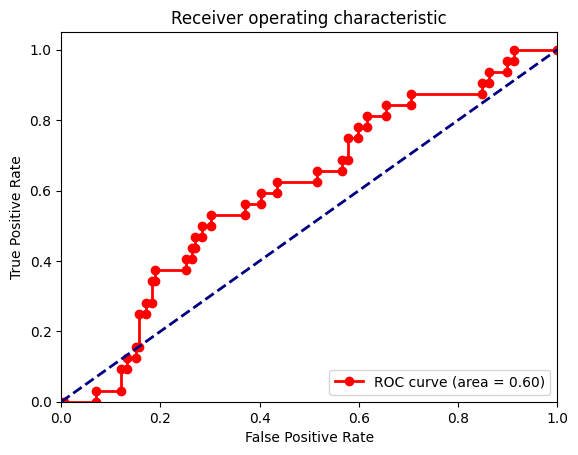

In [29]:
from sklearn import metrics

#ROC curve
fpr, tpr, thresh = metrics.roc_curve(y_true, y_score)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr,'ro-',# color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('/home/hyungyu/survival_analysis/paper_ex/classification/test.png')

from sklearn.metrics import classification_report, confusion_matrix
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names),'\n')

cm = confusion_matrix(y_true, y_pred)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print(f'tn : {tn}, fp : {fp}, fn : {fn}, tp : {tp}','\n')

cm = pd.DataFrame(np.flip(cm), columns=[['PRED']*2, ['1','0']], index=[['ACTUAL']*2, ['1', '0']])
# cm = pd.DataFrame(cm, columns=[['PRED']*2, ['0','1']], index=[['ACTUAL']*2, ['0', '1']])
# cm = pd.DataFrame(np.flip(cm), index=[['PRED']*2, ['1','0']], columns=[['ACTUAL']*2, ['1', '0']])
print(cm,'\n')



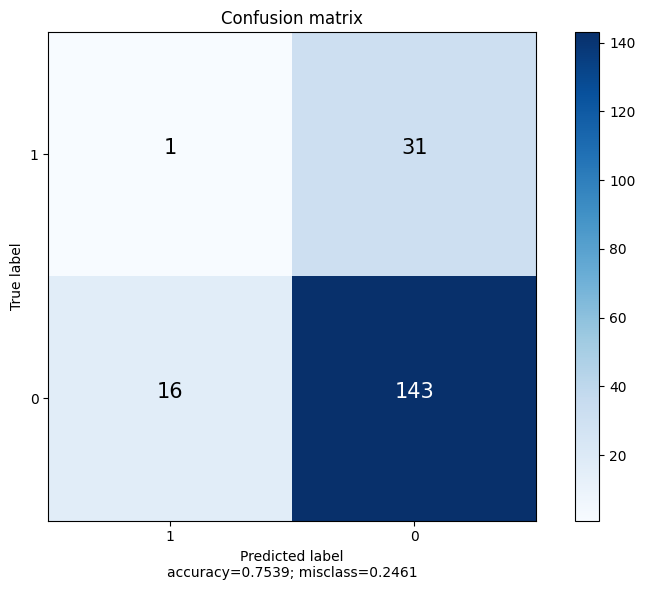

In [30]:
import itertools
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=False, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]), 
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]), fontsize=15,
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.tight_layout()
    plt.savefig('/home/hyungyu/survival_analysis/paper_ex/classification/testforwhat.png')
    
cm = metrics.confusion_matrix(y_true ,y_pred )
plot_confusion_matrix(np.flip(cm), target_names = ['1', '0'])



In [31]:
print( 'tp :', tp )
print( 'fn : ', fn)
print( 'tn : ', tn)
print( 'fp : ', fp)
print(' Sensitivity : ', tp / ( tp + fn))
print(' Specificity : ', 1 - (fp / (fp + tn)))
print( tn/ (tn + fp))

tp : 1
fn :  31
tn :  143
fp :  16
 Sensitivity :  0.03125
 Specificity :  0.89937106918239
0.89937106918239
